In [28]:
%matplotlib inline

# Automating a Microscope
---

## Motivation

Microscope slide scanners have significant potential to transform pathology practice. Its main function is the digitalization of glass slides, but through that process, they will also open a door for a wide array of other digital tools and algorithms, notably for machine learning (ML) and artificial intelligence (AI). In the last few years, these algorithms have demonstrated impressive results in image segmentation, object classification, and clinical outcomes prediction, in some cases even exceeding human-level performance.

Unfortunately, microscope slide scanners are still too expensive for many laboratories and hospitals, especially for veterinarians (to my knowledge there is only one slide scanner in Zagreb - at the National Institute for Brain Research). That makes this problem very relevant and, I hope, very interesting to solve.

We hope that this tutorial will show you that, despite the price of commercially available automated microscopes, even you can make one with just the python basics. More importantly, this task will help you develop a general principle for solving complex, real-world problems with python. In other words, you will learn how to program.

---

# The Code

In order to solve this problem, you will need to write a program with several functions. Functions are blocks of code
that are designed to do one specific job. Let's go quickly through each function that you will need to write:

### Controlling stepper motors
Our microscope will be automated with three stepper motors, each of them responsible for controlling one axis in a 3-dimensional space: 'x', 'y' and 'z' axis. In order to accomplish this task, we need to write a function **def move()** that takes three arguments: **axis** ('x', 'y' or 'z'), **n_steps** (number of steps; positive integer) and **direction** (1 or -1). 

There is already a lot of excellent tutorials on this subject and there is no need to write another one. Here are some tutorials I found very helpful:
1. [This video](https://www.youtube.com/watch?v=Dc16mKFA7Fo) explains both how stepper motors work, and how to control one using the Raspberry Pi in less than 10 minutes.
2. [The code in this video](https://www.youtube.com/watch?v=Dc16mKFA7Fo) is a little more complicated, but is still a great reference.

In [8]:
def move(axis, n_steps, direction):
    pass

### Capturing images
For this task, we are using a Sony mirrorless camera connected to a Raspberry Pi. In order to communicate with this camera, we'll be using the [python-gphoto2](https://github.com/jim-easterbrook/python-gphoto2) library, which is a Python interface to libgphoto2. Libgphoto2 is an open-source camera access and control library for Unix-like platforms (Linux and macOS).

You won't need to write this function. We'll just copy-paste it from the official GitHub repository (link above)

In [11]:
# This function is copy-pasted from python-gphoto2 repository (author: jim-easterbrook)
def capture(filename):
    print('Capturing image')
    file_path = gp.check_result(gp.gp_camera_capture(
        camera, gp.GP_CAPTURE_IMAGE))
    # maybe you will need to change this line of code
    target = os.path.join(os.getcwd(), filename) 
    camera_file = gp.check_result(gp.gp_camera_file_get(
            camera, file_path.folder, file_path.name, gp.GP_FILE_TYPE_NORMAL))
    gp.check_result(gp.gp_file_save(camera_file, target))
    gp.check_result(gp.gp_camera_exit(camera))
    return 0

### Calculating image sharpness

If we want to know how many steps and what direction we need to take on the **"z" axis**, we need to have a function that can calculate image sharpness.

**How do computers see an image?**

First of all, we need to understand that in computer memory standard color images are actually represented by three-dimensional matrices. Beside **width** and **height**, color images also have a third dimension: **depth** - three color channels (red, green, and blue).

It would be quite computationally expensive (and unnecessary) to work with all three channels. So, we'll convert every image to the single channel grayscale image. Now we have an 8-bit 2D matrix in which every pixel have an intensity between 0 and 255, with 0 being black and 255 being white:

![image_matrix](imgs/imagematrix.png)

In Python, with OpenCV library we can load an image and convert it to grayscale in just one line of code:

In [34]:
# We first need to import the OpenCV library
import cv2

im = cv2.imread("mastocytoma.jpg", cv2.IMREAD_GRAYSCALE)
im

array([[221, 216, 217, ..., 217, 217, 212],
       [220, 215, 216, ..., 214, 215, 213],
       [218, 215, 216, ..., 214, 216, 215],
       ...,
       [212, 212, 212, ..., 214, 212, 208],
       [211, 212, 212, ..., 216, 213, 209],
       [212, 213, 214, ..., 217, 215, 212]], dtype=uint8)

Let's display our image using Matplolib library:

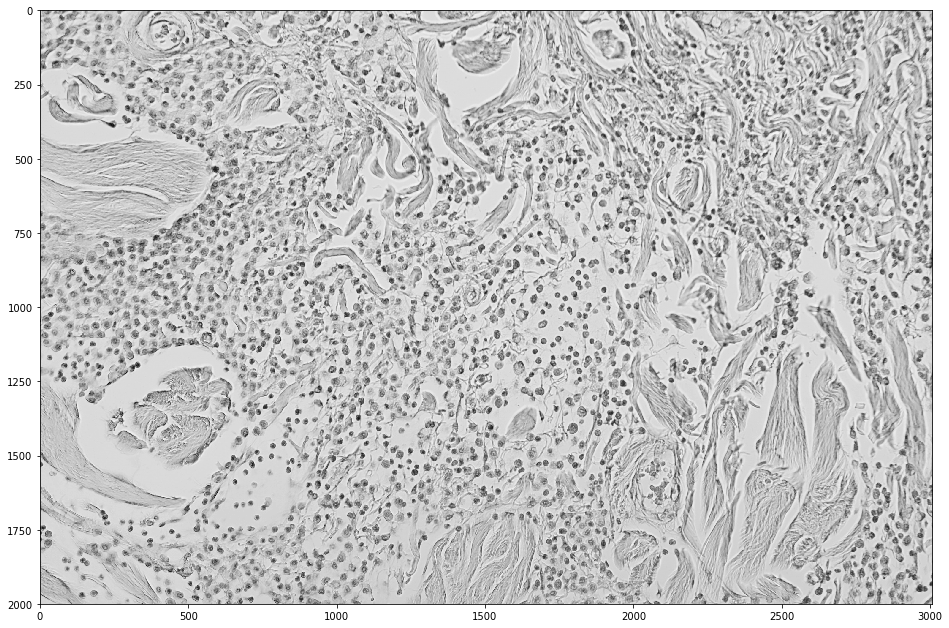

In [33]:
from matplotlib import pyplot as plt

plt.figure(figsize=(16, 24))
plt.imshow(im, cmap='gray')

Great! We successfully opened our image and converted it to grayscale. Now we need to calculate its sharpness. 

**But, what is image sharpness?** 

The sharpness of the image is the difference between its pixel values. Luckily for us, there is already a Numpy function that can calculate that for us: numpy.diff (You should read the [documentation](https://docs.scipy.org/doc/numpy/reference/generated/numpy.diff.html) and run a couple of examples to better understand what it is doing).

In [83]:
import numpy as np

dx = np.diff(im)[1:,:] # remove the first row
dy = np.diff(im, axis=0)[:,1:] # remove the first column

... and this is the rest of the code: 

In [117]:
dnorm = np.sqrt(dx**2 + dy**2)
sharpness = np.average(dnorm)
sharpness

6.254

Your task is to run this code line by line and understand what each line of code is doing. In your final script, you need to write a comment (an explanation) for each line of code in this function. You also need to figure it out why did we remove one row and one column after np.diff.

Let's turn this code into a function and calculate the sharpness of one more image:

In [133]:
def get_sharp(filename):
    im = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
    dx = np.diff(im)[1:,:] # remove the first row
    dy = np.diff(im, axis=0)[:,1:] # remove the first column
    dnorm = np.sqrt(dx**2 + dy**2)
    sharpness = np.average(dnorm)
    return sharpness

In [141]:
filename = "mastocytoma_blur.jpg"

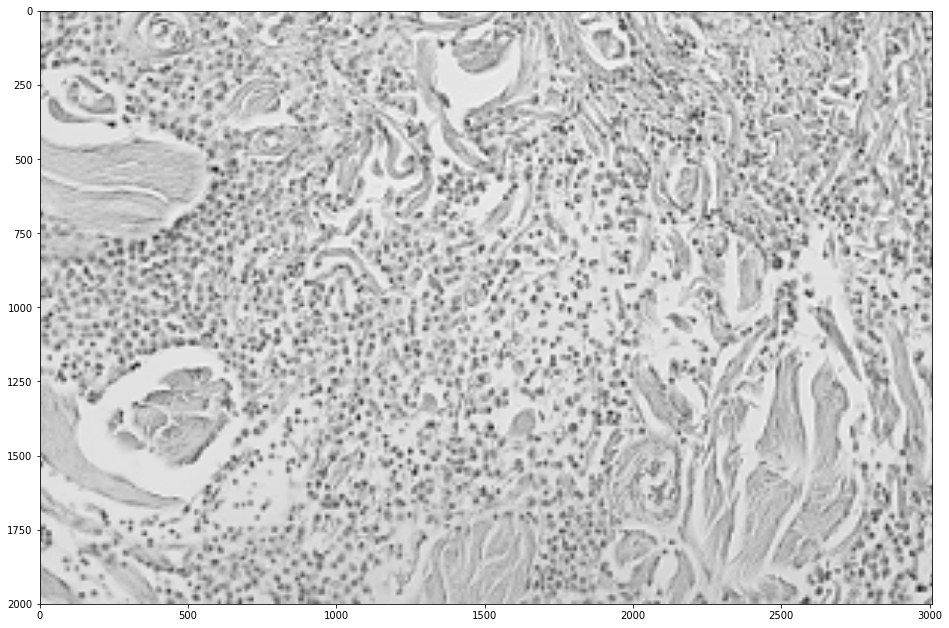

In [142]:
img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)
plt.figure(figsize=(16, 24))
plt.imshow(img, cmap='gray')

This image is more blurry. Let's call our function with this image as an argument!

In [143]:
get_sharp(filename)

2.545

The second image has sharpness of only 2.54 and, according to our algorithm, it is 2.5x less sharp (or more blurry) than the first image.

### Calculating image whiteness

We don't want to call the **get_sharp** function on every image, just on those images that have something on which the algorithm can focus. Therefore, we need an algorithm that will tell us if there is something in the image, or the image is empty (white). The simplest algorithm (but probably not the best) is one that calculates the percentage of white pixels in a given image. 

You'll need to write this function yourself! You already know how to load images using OpenCV and you also know that every pixel has a value between 0 and 255. Here are two more tips:
1. "White" pixels in photographs are rarely actually white (they rarely have a value of 255). They are usually just light gray. Therefore, you need to set up a **threshold** and tell the computer that every pixel with a value higher than that threshold is white (This number depends on the amount of light and camera settings)
2. You need to start thinking about the speed of your algorithms. Our images will have around 6 million pixels (6MB images). That's a lot of pixels and you don't want to iterate through each one. Try to pick up a random sample of 800 pixels and iterate through them. Numpy can help here!

In [140]:
def whiteness(filename):
    pass

# Putting it all together

In order to automate the microscope, you'll need to put these functions together into one logical unit. 

Good luck!

